# Packages

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import cellrank as cr
from moscot.problems.time import TemporalProblem

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import gc

# Functions

In [ ]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=30,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

# Setup

## Loading

In [ ]:
data_path = "/path/to/data/"

adata = sc.read_h5ad(f"{data_path}lc_cleaned.h5ad")

## Colors

In [ ]:
colors_hex = [
    "#8c510a",
    "#bf812d",
    "#dfc27d",
    "#c7eae5",
    "#80cdc1",
    "#35978f",
    "#01665e",
]
timepoint_colors = {
    key: colors_hex[i] for i, key in enumerate(adata.obs["timepoint"].cat.categories)
}

In [ ]:
colors_hex = [
    "#66c5cc",
    "#f6cf71",
    "#f89c74",
    "#dcb0f2",
    "#87c55f",
    "#9eb9f3",
    "#fe88b1",
    "#c9db74",
    "#8be0a4",
    "#b497e7",
    "#d3b484",
    "#b3b3b3",
    "#89fade",
    "#817157",
    "#132b58",
]
leiden_colors = {f"{i}": colors_hex[i] for i in range(15)}

# PAGA

In [ ]:
sc.tl.paga(adata, groups="leiden")

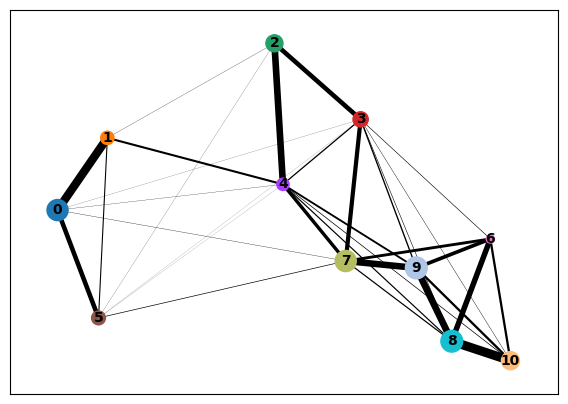

In [ ]:
sc.pl.paga(adata, color="leiden")

In [ ]:
sc.pl.umap(
    adata,
    color='timepoint',
    palette=timepoint_colors,
)

In [ ]:
sc.tl.draw_graph(adata, init_pos="paga")

# Cellrank

## Kernels

### RealTimeKernel

#### Moscot

In [ ]:
adata.obs["timepoint_num_cat"] = adata.obs["timepoint"].map(
    {key: i for i, key in enumerate(adata.obs["timepoint"].cat.categories)}
)

adata.obs["timepoint_num"] = adata.obs["timepoint_num_cat"].astype("float")

In [ ]:
tp = TemporalProblem(adata)

In [ ]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

       'Rps27l'],
      dtype='object')


In [ ]:
tp = tp.prepare(time_key="timepoint_num_cat")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                                                                                                                                                                                                                                                                                                                                                   
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                                                                                                                                                                                                                                                                                                                                                   
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                             

In [ ]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `6` problems                                                                                                                                                                                                                                                                                                                                                                                                                       
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3213, 2074)].                                                                                                                                                                                                                                                                                                                                                                   


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2074, 2129)].                                                                                                                                                                                                                                                                                                                                                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1997, 1835)].                                                                                                                                                                                                                                                                                                                                                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2129, 1997)].                                             

In [ ]:
tmk = cr.kernels.RealTimeKernel.from_moscot(tp)

In [ ]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2)

100%|██████████| 6/6 [00:00<00:00, 40590.04time pair/s]


RealTimeKernel[n=17740, threshold='auto', self_transitions='all']

### Connectivity kernel

In [ ]:
ck = cr.kernels.ConnectivityKernel(adata)

In [ ]:
ck.compute_transition_matrix()

ConnectivityKernel[n=17740, dnorm=True, key='connectivities']

### Combined Kernel

In [ ]:
combined_kernel = 0.99 * tmk + 0.01 * ck

In [ ]:
combined_kernel.compute_transition_matrix()

(0.99 * RealTimeKernel[n=17740, threshold='auto', self_transitions='all'] + 0.01 * ConnectivityKernel[n=17740, dnorm=True, key='connectivities'])

## Estimators

### GPCCA

In [ ]:
g = cr.estimators.GPCCA(combined_kernel)

print(g)

GPCCA[kernel=(0.99 * RealTimeKernel[n=17740] + 0.01 * ConnectivityKernel[n=17740]), initial_states=None, terminal_states=None]


/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


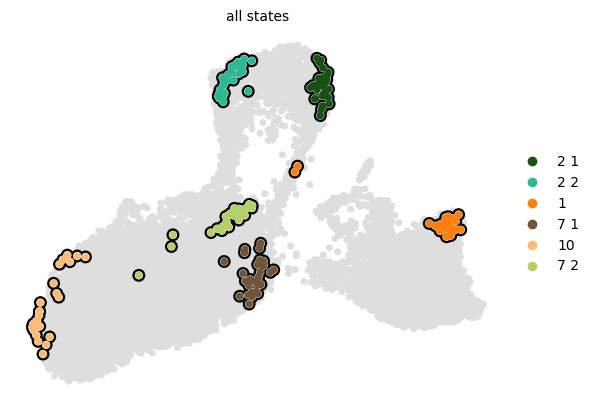

In [ ]:
g.fit(cluster_key="leiden", n_states=[4, 21])
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


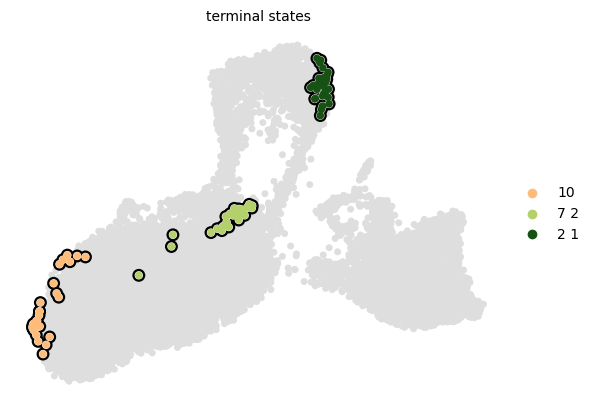

In [ ]:
g.predict_terminal_states(method="top_n", n_states=3)
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


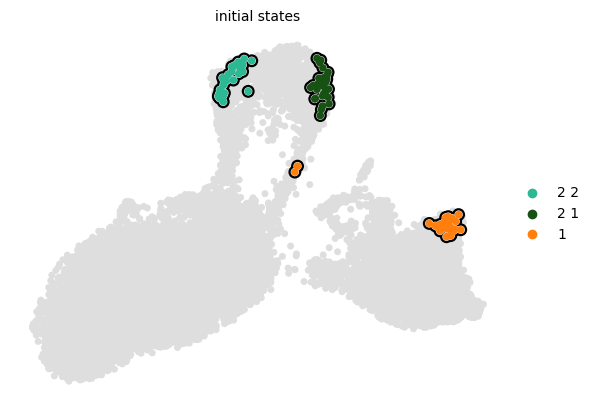

In [ ]:
g.predict_initial_states(n_states=3, allow_overlap=True)
g.plot_macrostates(which="initial", legend_loc="right", s=100)

In [ ]:
g.set_initial_states(["1"])
g.set_terminal_states(["10", "2_1"])

GPCCA[kernel=(0.99 * RealTimeKernel[n=17740] + 0.01 * ConnectivityKernel[n=17740]), initial_states=[np.str_('1')], terminal_states=[np.str_('10'), np.str_('2_1')]]

100%|██████████| 2/2 [00:00<00:00,  3.91/s]


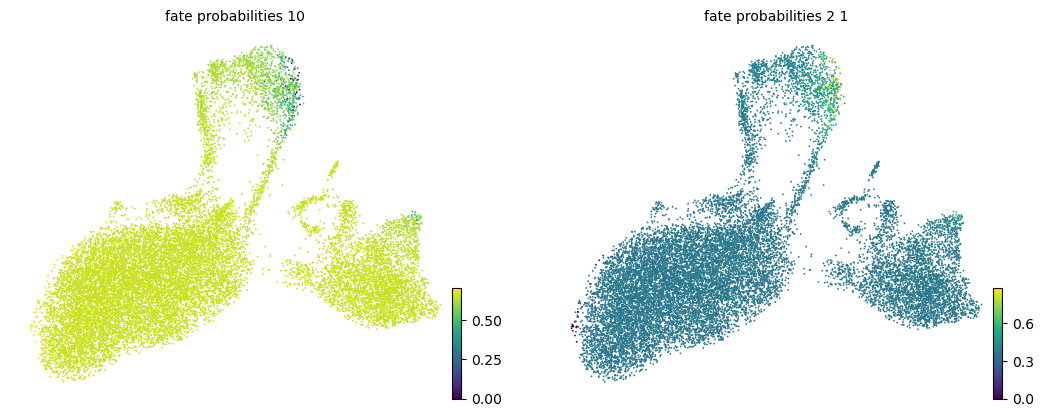

In [ ]:
g.compute_fate_probabilities(tol=1e-12)
g.plot_fate_probabilities(same_plot=False)

### Pseudotime

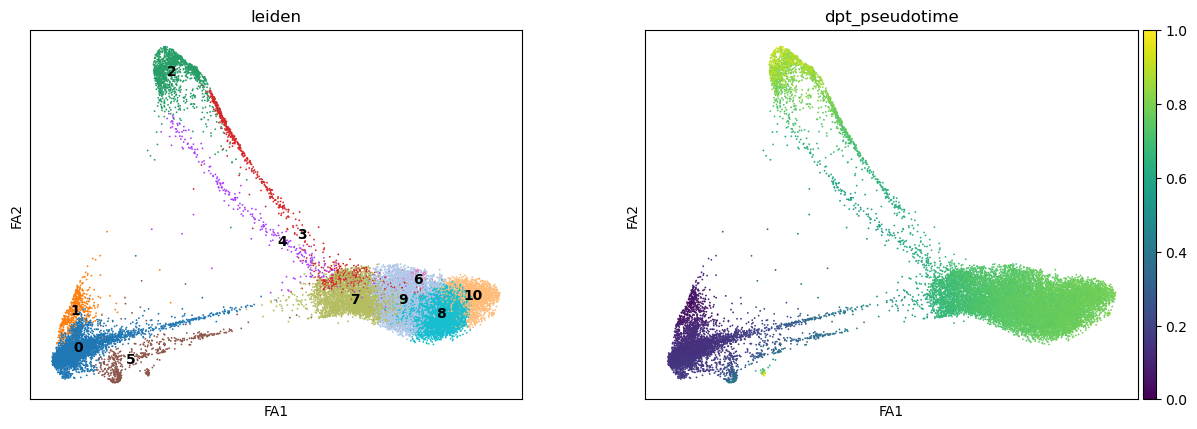

In [ ]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["init_states_fwd"] == "1")[0]

sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=["leiden", "dpt_pseudotime"], legend_loc="on data")

### Gene expression trends

In [ ]:
model = cr.models.GAM(
    adata,
    n_knots=10,
)

 91%|█████████▏| 1828/2000 [09:38<02:01,  1.41gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge


100%|█████████▉| 1998/2000 [11:46<00:07,  3.86s/gene]

did not converge
did not converge
did not converge
did not converge
did not converge


100%|██████████| 2000/2000 [11:54<00:00,  2.80gene/s]


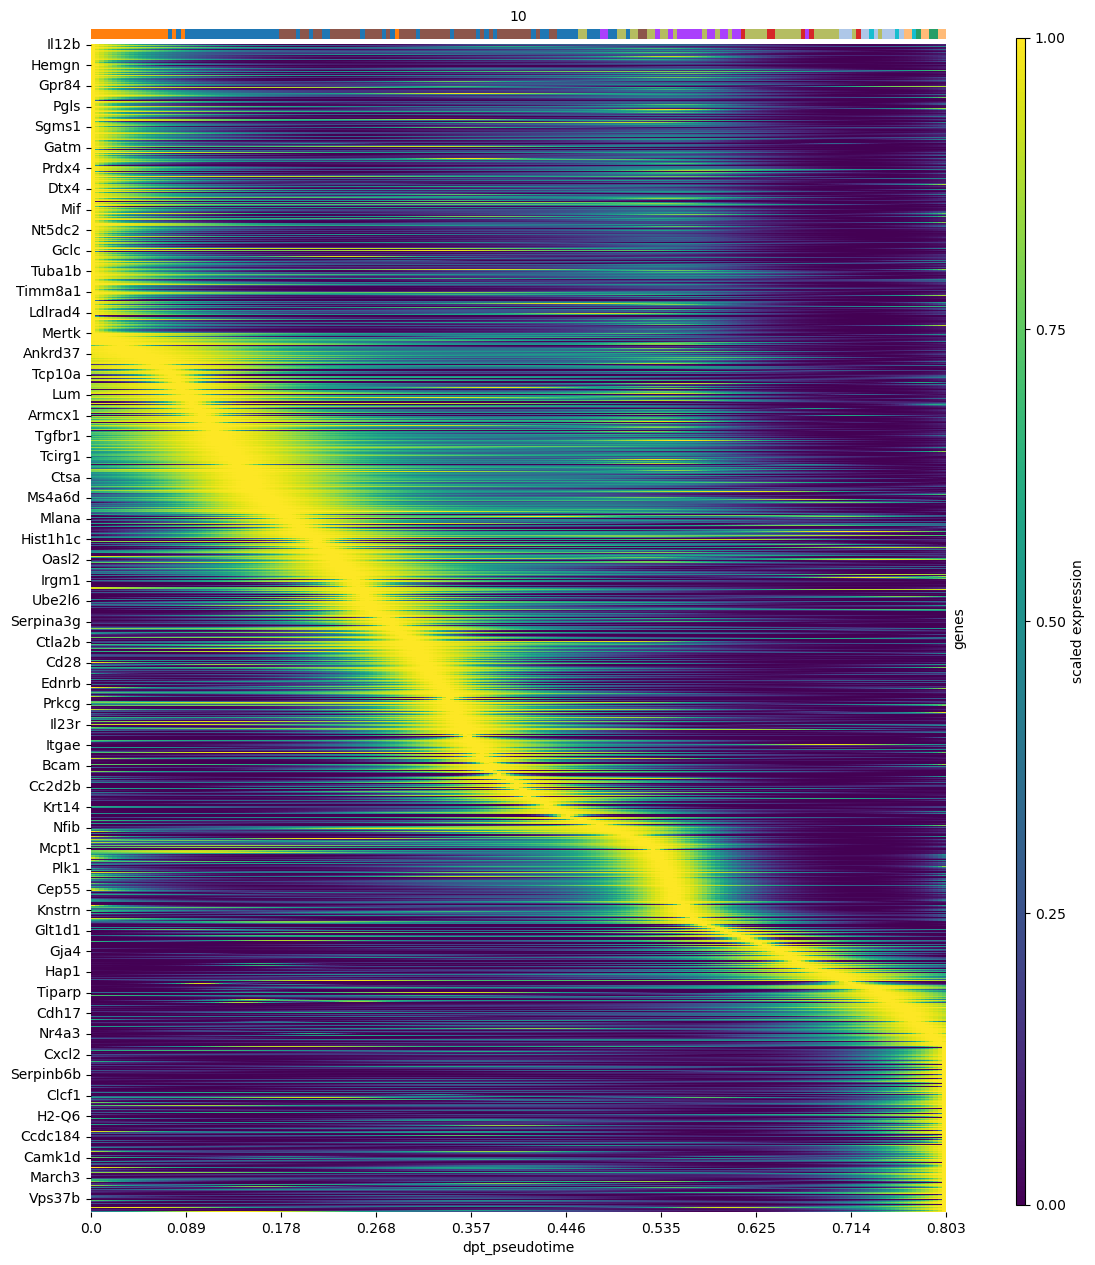

In [ ]:
heatmap_results = cr.pl.heatmap(
    adata,
    model=model,
    lineages="10",
    cluster_key="timepoint",
    show_fate_probabilities=False,
    data_key="log1p_norm",
    genes=adata[:, adata.var["highly_variable"]].var_names,
    time_key="dpt_pseudotime",
    figsize=(12, 15),
    show_all_genes=False,
    cluster_genes=False,
    weight_threshold=(1e-3, 1e-3),
    n_jobs=16,
    return_figure=True,
    return_genes=True,
    return_models=True,
)

gc.collect()

### Cluster gene expression trends

  0%|          | 0/2000 [00:00<?, ?gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not conver

 96%|█████████▋| 1929/2000 [15:03<00:13,  5.15gene/s]  

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


100%|██████████| 2000/2000 [16:45<00:00,  1.99gene/s]


did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


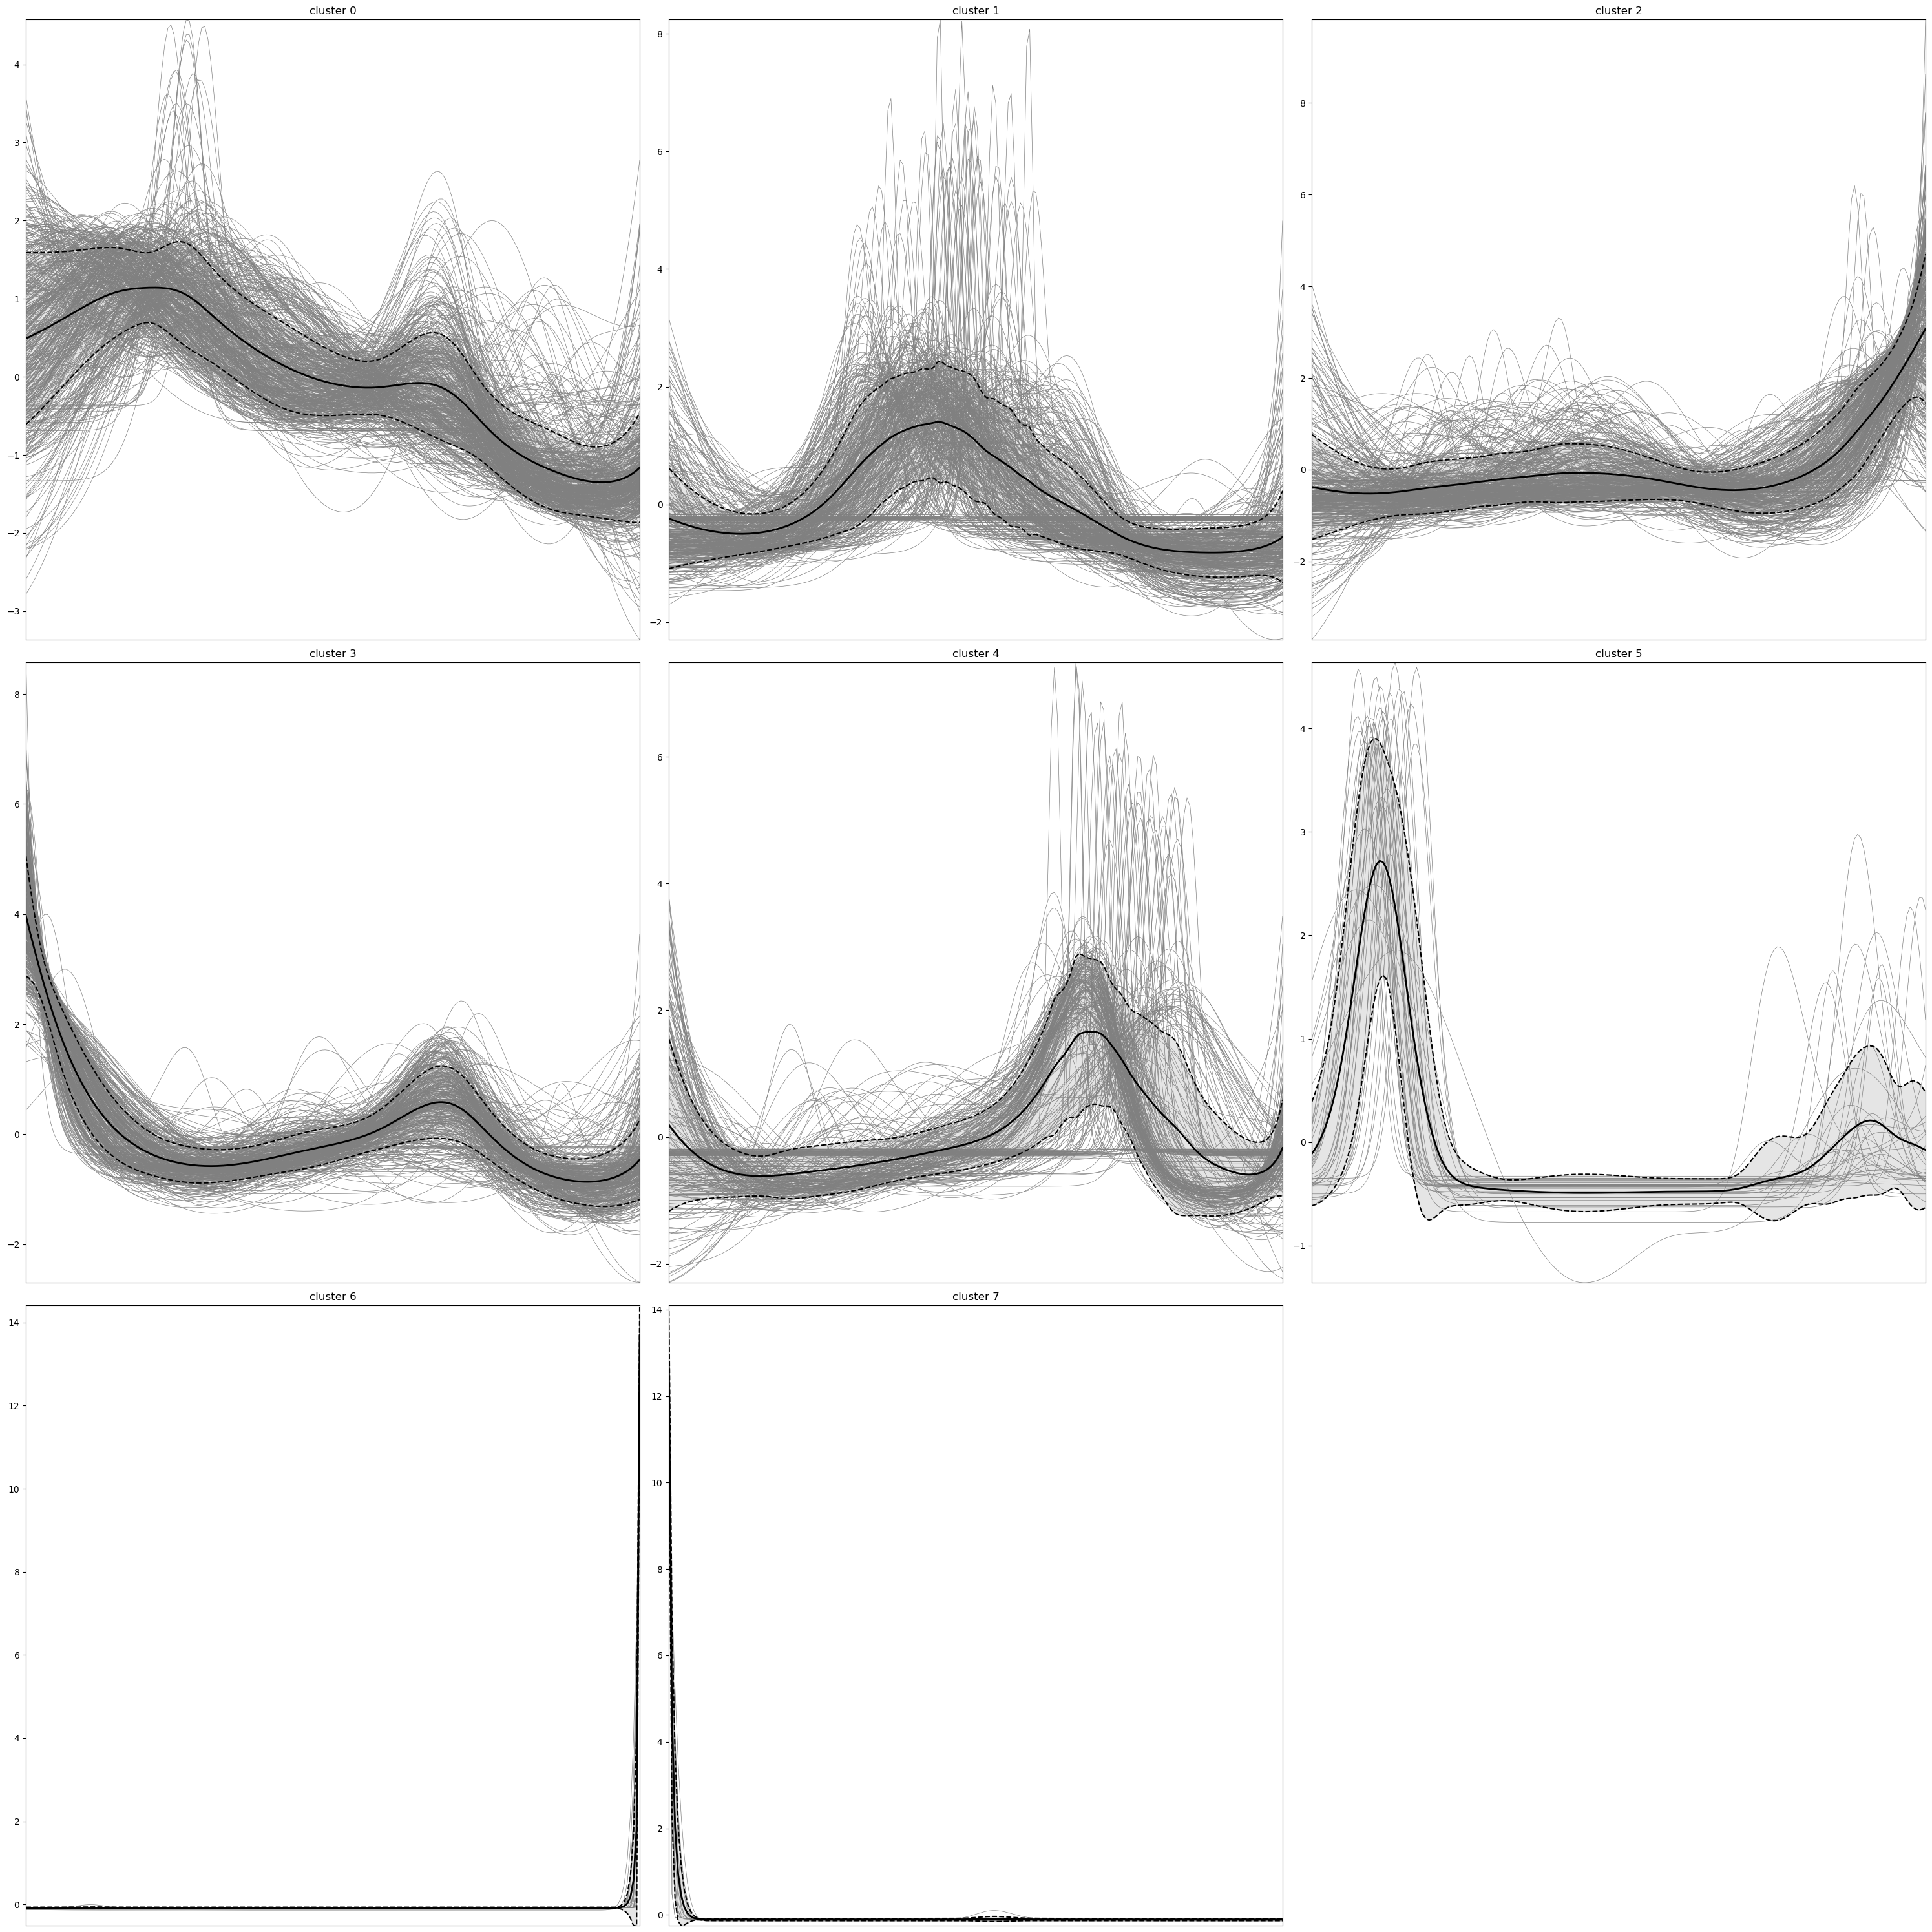

In [ ]:
cr.pl.cluster_trends(
    adata,
    model=model,
    lineage="10",
    data_key="log1p_norm",
    genes=adata[:, adata.var["highly_variable"]].var_names,
    time_key="dpt_pseudotime",
    weight_threshold=(1e-3, 1e-3),
    n_jobs=8,
    random_state=0,
    clustering_kwargs={"resolution": 0.2, "random_state": 0},
    neighbors_kwargs={"random_state": 0},
)

In [ ]:
gdata = adata.uns["lineage_10_trend"].copy()
gdata

AnnData object with n_obs × n_vars = 1871 × 200
    obs: 'clusters'
    var: 'x_test'
    uns: 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
gdata.obs = gdata.obs.merge(
    right=adata.var[["means", "variances"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Figures

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

In [ ]:
umap_dot_size = 250000 / adata.n_obs
print(umap_dot_size)

14.092446448703495


In [ ]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60 / 25.4
plot_height_in = 45 / 25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6 / 25.4

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

## Pseudotime

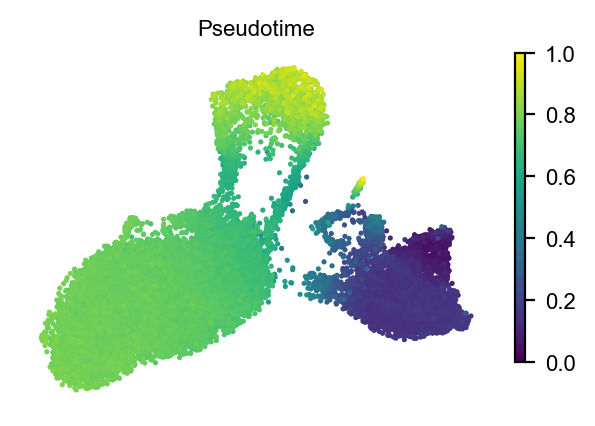

In [ ]:
margin_right = (
    15 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata,
    basis="X_umap",
    color="dpt_pseudotime",
    ax=axes,
    title="Pseudotime",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

In [ ]:
fig_width = fig.get_figwidth()

## PAGA graph

In [ ]:
embedding = pd.DataFrame(
    adata.obsm["X_umap"], index=adata.obs_names, columns=["UMAP_1", "UMAP_2"]
)

metadata = sc.get.obs_df(adata, keys=["leiden"])

embedding = embedding.merge(metadata, left_index=True, right_index=True)

embedding_medians = embedding.groupby("leiden").median()

In [ ]:
adata.uns["leiden_colors"] = list(leiden_colors.values())[0:11]

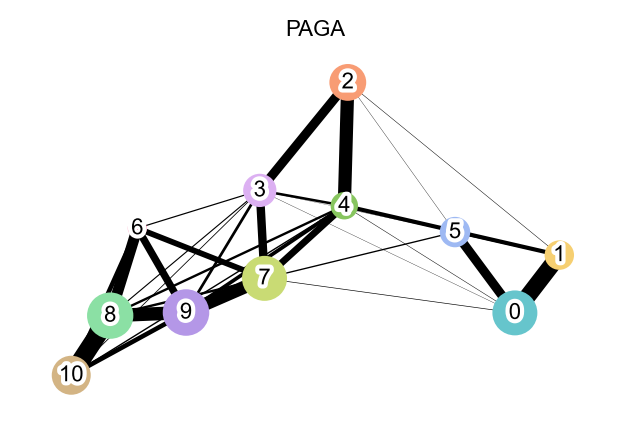

In [ ]:
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")

sc.pl.paga(
    adata,
    color="leiden",
    pos=np.array(embedding_medians),
    frameon=False,
    title="PAGA",
    show=False,
    ax=axes,
    fontsize=8,
    fontweight="normal",
    fontoutline=3,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        (plot_width_in + margin_right) / fig_width,
        plot_height_in / fig_height,
    ]
)

## Heatmap

In [ ]:
colors = [
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]

gene_module_colors = {
    key: colors[i] for i, key in enumerate(gdata.obs["clusters"].cat.categories)
}

In [ ]:
genes_of_interest = [
    "Cx3cr1",
    "Zeb2",
    "Adgre1",
    "Fcgr1",
    "Mrc1",
    "Mertk",
    "Apoe",
    "Hexb",
    "Aif1",
    "Tmem119",
    "Trem2",
    "P2ry12",
    "Csf2rb",
    "Tgfbr1",
    "Id2",
    "Irf8",
    "Klf3",
    "Klf4",
    "Cebpa",
    "Cebpb",
    "C1qb",
    "C1qc",
    "C1qa",
    "H2-M2",
    "Cd207",
    "Epcam",
    "Siglech",
    "Top2a",
    "Itgam",
    'Mki67'
]

y_positions = []

for gene in genes_of_interest:
    y_positions.append(heatmap_results[1][heatmap_results[1]["10"] == gene].index[0])

y_positions = np.array(y_positions)

In [ ]:
def spread_labels(y_positions, min_dist=50):
    y_positions = np.array(y_positions, dtype=float)
    idx_sort = np.argsort(y_positions)
    y_sorted = y_positions[idx_sort]
    # .astype(float)  

    y_adjusted = y_sorted.copy()

    # Loop over all of them and shift them downwards (increasing y) if they are too close
    for i in range(1, len(y_adjusted)):
        if y_adjusted[i] - y_adjusted[i - 1] < min_dist:
            y_adjusted[i] = y_adjusted[i - 1] + min_dist

    # shift all of them back up by the median so that they don't all shift downwards in a cascading effect
    shift = np.median(y_sorted - y_adjusted)
    y_adjusted += shift

    for _ in range(10):
        for i in range(0, len(y_adjusted)-1):

            new_y = y_adjusted[i+1] - min_dist
            # Only move down if there’s extra space and we don’t go below original
            if y_adjusted[i] < new_y and new_y < y_sorted[i]:
                y_adjusted[i] = new_y
            # Otherwise, if there’s extra space but moving to original is possible
            elif y_adjusted[i] < new_y and y_sorted[i] < new_y:
                y_adjusted[i] = y_sorted[i]

    # Handle last label separately since in our case it is never checked in the previous loop
    last_i = len(y_adjusted) - 1
    if y_adjusted[last_i] < y_sorted[last_i]:
        y_adjusted[last_i] = y_sorted[last_i]

    y_final = np.empty_like(y_adjusted)
    y_final[idx_sort] = y_adjusted

    return y_final

In [ ]:
heatmap_gene_trends = heatmap_results[0][0]

In [ ]:
y_final = spread_labels(y_positions, min_dist=60)

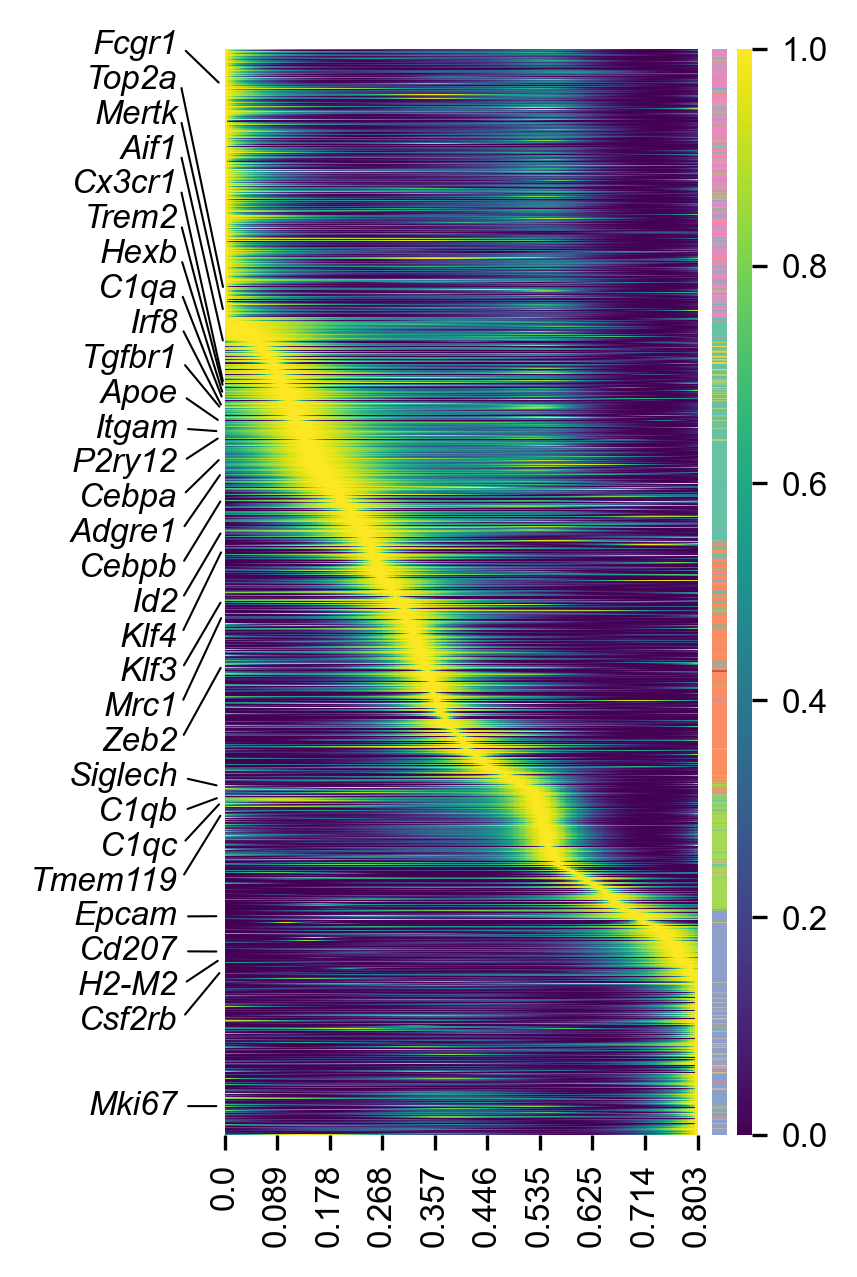

In [ ]:
fig, ax_heatmap = plt.subplots(
    1, 1, figsize=(70 / 25.4, 105.195 / 25.4), dpi=300, layout="constrained"
)

sns.heatmap(
    heatmap_gene_trends.data2d,
    cmap="viridis",
    ax=ax_heatmap,
    cbar_kws={"shrink": 1, "aspect": 70},
)

ax_heatmap.set_ylabel("")
ax_heatmap.set_xticks(heatmap_gene_trends.fig.get_axes()[3].get_xticks())
ax_heatmap.set_xticklabels(heatmap_gene_trends.fig.get_axes()[3].get_xticklabels())
ax_heatmap.set_yticks([])
ax_heatmap.set_yticklabels([])

for orig, shifted, label in zip(
    y_positions, y_final, genes_of_interest
):
    tx, ty = -20, shifted
    ax_heatmap.text(tx, ty, label, ha="right", va="center", fontsize=8, style='italic')

    ax_heatmap.annotate(
        "",
        xy=(0, orig),
        xytext=(tx + 1, ty),
        xycoords="data",
        textcoords="data",
        arrowprops=dict(arrowstyle="-", lw=0.5, color="black", connectionstyle="arc3"),
    )


ax_cluster_colorbar = inset_axes(
    ax_heatmap,
    width="3%",
    height="100%",
    loc="center right",
    bbox_to_anchor=(
        0.06,
        0,
        1,
        1,
    ),
    bbox_transform=ax_heatmap.transAxes,
    borderpad=0,
)

clusters = (
    pd.DataFrame(gdata.obs["clusters"])
    .reindex(heatmap_results[1]["10"])
    .reset_index()
    .rename(columns={"10": "gene"})["clusters"]
)
row_colors = [gene_module_colors.get(num, "black") for num in clusters]

rgb_colors = [mcolors.to_rgb(c) for c in row_colors]

ax_cluster_colorbar.imshow(
    np.array([rgb_colors]).reshape(-1, 1, 3),
    aspect="auto",
)
ax_cluster_colorbar.set_axis_off()

## Handpicked genes

In [ ]:
handpicked_genes = [
    "Adgre1",
    "P2ry12",
    "Top2a",
    "H2-M2",
]

genes_to_module = gdata.obs["clusters"].loc[handpicked_genes]

100%|██████████| 4/4 [00:00<00:00,  5.60gene/s]
<positron-console-cell-94>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-94>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


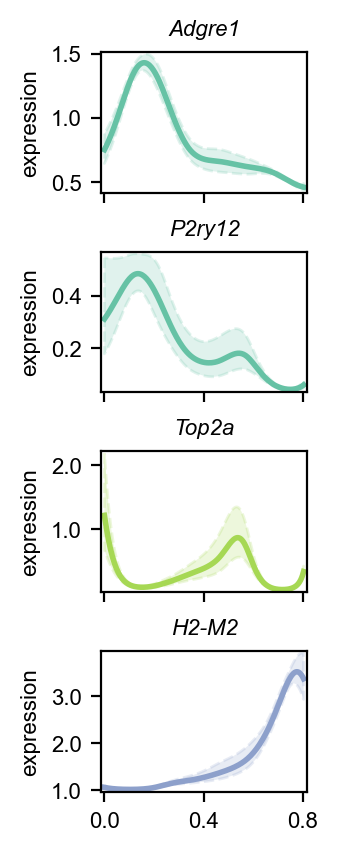

In [ ]:
p1 = cr.pl.gene_trends(
    adata,
    model=model,
    lineages=["10"],
    data_key="log1p_norm",
    genes=handpicked_genes,
    same_plot=True,
    ncols=1,
    hide_cells=True,
    time_key="dpt_pseudotime",
    weight_threshold=(1e-3, 1e-3),
    return_figure=True,
    figsize=(40/25.4, 105.195/25.4),
    dpi=200,
    legend_loc=None,
)

for i, axes in enumerate(p1.get_axes()):
    axes.set_xticks([0, 0.4, 0.8])
    axes.set_title(axes.get_title(), style='italic')

    axes.get_lines()[0].set_color(gene_module_colors[genes_to_module.iloc[i]])
    axes.collections[0].set_facecolor(gene_module_colors[genes_to_module.iloc[i]])
    axes.collections[0].set_edgecolor(gene_module_colors[genes_to_module.iloc[i]])

p1.get_axes()[3].set_xlabel('')

p1.get_axes()[2].set_yticklabels([0,1.0,2.0])
p1.get_axes()[3].set_yticklabels([0,1.0,2.0,3.0])

p1.set_constrained_layout(True)

# Supplementary Figures

## Macrostates

In [ ]:
macrostates_colors = {
    '1': '#126857',
    '10': '#5ab4ac',
    '2_1': '#d8b365',
}

In [ ]:
adata.obs['macrostates_custom'] = adata.obs['term_states_fwd'].combine_first(adata.obs['init_states_fwd'])

/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


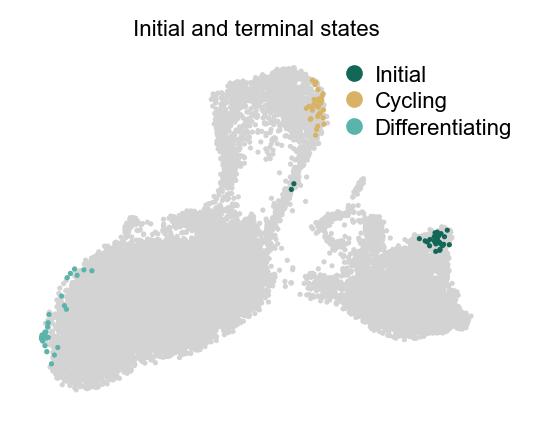

In [ ]:
margin_right = 5/25.4

fig_width = margin_left + plot_width_in + legend_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout='constrained')

embedding_shuffled(
    adata,
    basis="X_umap",
    ax=axes,
    size=umap_dot_size,
)

embedding_shuffled(
    adata[~adata.obs['macrostates_custom'].isna()],
    basis="X_umap",
    ax=axes,
    size=umap_dot_size,
    color='macrostates_custom',
    palette=macrostates_colors,
    legend_fontsize=8,
    legend_loc=None
)

axes.set_position([
    margin_left / fig_width,
    margin_bottom / fig_height,
    plot_width_in / fig_width,
    plot_height_in / fig_height
])

axes.set_title('Initial and terminal states')

markersize=5

handles = [
    mlines.Line2D([], [], color=macrostates_colors['1'],
                  marker='o', linestyle='None',
                  markersize=markersize, label='Initial'),
    mlines.Line2D([], [], color=macrostates_colors['2_1'],
                  marker='o', linestyle='None',
                  markersize=markersize, label='Cycling'),
    mlines.Line2D([], [], color=macrostates_colors['10'],
                  marker='o', linestyle='None',
                  markersize=markersize, label='Differentiating'),
]
fig.legend(
    handles = handles,
    labels=['Initial', 'Cycling', 'Differentiating'],
    loc='upper right', frameon=False, bbox_to_anchor=(1.0, 0.9), labelspacing=0.3, handletextpad=-0.1
)

## Gene modules

In [ ]:
df_gene_modules = pd.DataFrame(
    gdata.X,
    index=gdata.obs_names,
    columns=gdata.var_names
)

df_gene_modules['gene_module'] = gdata.obs['clusters']

In [ ]:
def plot_gene_module_with_colorbar(data, gs, title=None, color=None, rgb_colseries=None):

    gs_main = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=gs, height_ratios=[20, 1]
    )

    ax_lineplot = fig.add_subplot(gs_main[0])
    ax_colorbar = fig.add_subplot(gs_main[1])

    if color is None:
        color = 'gray'

    mean = data.mean()
    std = data.std()

    for row in data.iterrows():
        ax_lineplot.plot(row[1], color=color, alpha=0.1)
    ax_lineplot.plot(mean, color='black', linewidth=2)
    ax_lineplot.plot(mean-std, color='black', linewidth=1, linestyle='--')
    ax_lineplot.plot(mean+std, color='black', linewidth=1, linestyle='--')
    ax_lineplot.fill_between(range(len(mean)), mean - std, mean + std, color='black', alpha=0.1)

    ax_lineplot.set_xticks([])
    ax_lineplot.set_xticklabels([])

    if title is not None:
        ax_lineplot.set_title(title)
    if rgb_colseries is not None:
        ax_colorbar.imshow(
            np.array([rgb_colseries]), 
            aspect="auto",
        )

        ax_colorbar.set_axis_off()

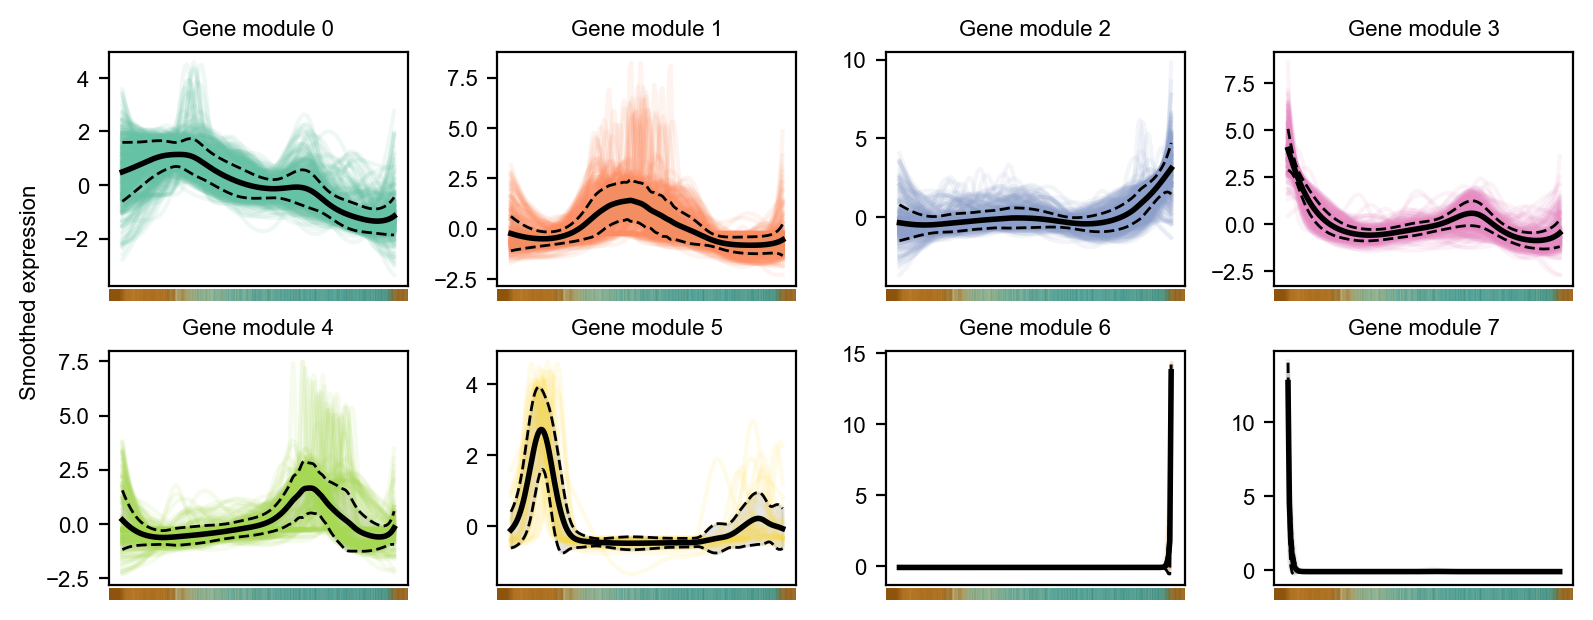

In [ ]:
fig = plt.figure(figsize=(199.992/25.4, 80/25.4), dpi=200)

fig.subplots_adjust(
    left=0.06,
    right=0.99,
    bottom=0.01,
    top=0.88,
    wspace=0.3,
    hspace=0.03
)

gs_main = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2)

tp_colbar = heatmap_gene_trends.col_colors[0]

for i, gene_module in enumerate(df_gene_modules["gene_module"].cat.categories):

    plot_gene_module_with_colorbar(
        df_gene_modules[df_gene_modules["gene_module"] == gene_module].drop(
            "gene_module", axis=1
        ),
        gs = gs_main[i],
        title=f'Gene module {gene_module}',
        color=gene_module_colors[gene_module],
        rgb_colseries=tp_colbar
    )

fig.text(
    0.01,
    0.5,
    "Smoothed expression",
    va="center",
    ha="center",
    rotation="vertical",
)